## Multi-label classification

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
from fastai.conv_learner import *

In [3]:
PATH = 'data/planet/'

In [4]:
# # Data preparation steps if you are using Crestle:

# os.makedirs('data/planet/models', exist_ok=True)
# os.makedirs('/cache/planet/tmp', exist_ok=True)

# !ln -s /datasets/kaggle/planet-understanding-the-amazon-from-space/train-jpg {PATH}
# !ln -s /datasets/kaggle/planet-understanding-the-amazon-from-space/test-jpg {PATH}
# !ln -s /datasets/kaggle/planet-understanding-the-amazon-from-space/train_v2.csv {PATH}
# !ln -s /cache/planet/tmp {PATH}

ln: failed to create symbolic link 'data/planet/train-jpg': No such file or directory
ln: failed to create symbolic link 'data/planet/test-jpg': No such file or directory
ln: failed to create symbolic link 'data/planet/train_v2.csv': No such file or directory
ln: failed to create symbolic link 'data/planet/tmp': No such file or directory


In [5]:
ls {PATH}

Parameterformat nicht ordnungsgem„á - "planet".


## Multi-label versus single-label classification

In [6]:
from fastai.plots import *

In [7]:
def get_1st(path): return glob(f'{path}/*.*')[0]

In [1]:
dc_path = "data/dogscats/valid/"
list_paths = [get_1st(f"{dc_path}cats"), get_1st(f"{dc_path}dogs")]
plots_from_files(list_paths, titles=["cat", "dog"], maintitle="Single-label classification")

NameError: name 'get_1st' is not defined

In single-label classification each sample belongs to one class. In the previous example, each image is either a *dog* or a *cat*.

FileNotFoundError: [Errno 2] No such file or directory: 'data/planet/train-jpg/train_0.jpg'

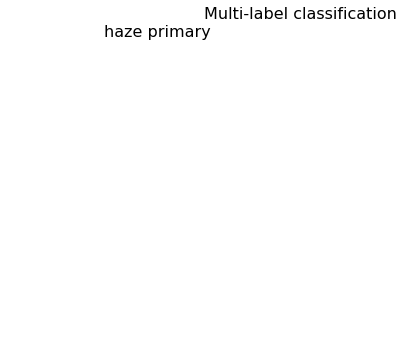

In [11]:
list_paths = [f"{PATH}train-jpg/train_0.jpg", f"{PATH}train-jpg/train_1.jpg"]
titles=["haze primary", "agriculture clear primary water"]
plots_from_files(list_paths, titles=titles, maintitle="Multi-label classification")

In multi-label classification each sample can belong to one or more classes. In the previous example, the first images belongs to two classes: *haze* and *primary*. The second image belongs to four classes: *agriculture*, *clear*, *primary* and  *water*.

## Multi-label models for Planet dataset

In [9]:
from planet import f2

metrics=[f2]
f_model = resnet34

In [10]:
label_csv = f'{PATH}train_v2.csv'
n = len(list(open(label_csv)))-1
val_idxs = get_cv_idxs(n)

FileNotFoundError: [Errno 2] No such file or directory: 'data/planet/train_v2.csv'

We use a different set of data augmentations for this dataset - we also allow vertical flips, since we don't expect vertical orientation of satellite images to change our classifications.

In [ ]:
def get_data(sz):
    tfms = tfms_from_model(f_model, sz, aug_tfms=transforms_top_down, max_zoom=1.05)
    return ImageClassifierData.from_csv(PATH, 'train-jpg', label_csv, tfms=tfms,
                    suffix='.jpg', val_idxs=val_idxs, test_name='test-jpg')

In [ ]:
data = get_data(256)

In [ ]:
x,y = next(iter(data.val_dl))

In [ ]:
y

In [ ]:
list(zip(data.classes, y[0]))

In [ ]:
plt.imshow(data.val_ds.denorm(to_np(x))[0]*1.4);

In [ ]:
sz=64

In [ ]:
data = get_data(sz)

In [ ]:
data = data.resize(int(sz*1.3), 'tmp')

In [ ]:
learn = ConvLearner.pretrained(f_model, data, metrics=metrics)

In [ ]:
lrf=learn.lr_find()
learn.sched.plot()

In [ ]:
lr = 0.2

In [ ]:
learn.fit(lr, 3, cycle_len=1, cycle_mult=2)

In [ ]:
lrs = np.array([lr/9,lr/3,lr])

In [ ]:
learn.unfreeze()
learn.fit(lrs, 3, cycle_len=1, cycle_mult=2)

In [ ]:
learn.save(f'{sz}')

In [ ]:
learn.sched.plot_loss()

In [ ]:
sz=128

In [ ]:
learn.set_data(get_data(sz))
learn.freeze()
learn.fit(lr, 3, cycle_len=1, cycle_mult=2)

In [ ]:
learn.unfreeze()
learn.fit(lrs, 3, cycle_len=1, cycle_mult=2)
learn.save(f'{sz}')

In [ ]:
sz=256

In [ ]:
learn.set_data(get_data(sz))
learn.freeze()
learn.fit(lr, 3, cycle_len=1, cycle_mult=2)

In [ ]:
learn.unfreeze()
learn.fit(lrs, 3, cycle_len=1, cycle_mult=2)
learn.save(f'{sz}')

In [ ]:
multi_preds, y = learn.TTA()
preds = np.mean(multi_preds, 0)

In [ ]:
f2(preds,y)

### End